In [1]:
#Import libraries
import urllib.request
import shutil
import os
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from sklearn import linear_model

In [2]:
final_path = 'data/burrs'
if os.path.isdir(final_path):
    shutil.rmtree(final_path)

#Download burrs dataset
url_scayle = "https://ss3.scayle.es/burr/original.zip"
path_burrs = 'data/burrs.zip'
urllib.request.urlretrieve(url_scayle,path_burrs)
shutil.unpack_archive(path_burrs, 'data')
os.rename('data/original', final_path)

url_scayle_file = "https://ss3.scayle.es:443/burr/info_category.csv"
path_burrs_file = 'data/info_category.csv'
urllib.request.urlretrieve(url_scayle_file,path_burrs_file)

('data/info_category.csv', <http.client.HTTPMessage at 0x1c500ea6b08>)

In [3]:
data = pd.read_csv(path_burrs_file, delimiter=';')  
data_k = data[data.category==1].reset_index()
data_s = data[data.category==2].reset_index()
data_b = data[data.category==3].reset_index()

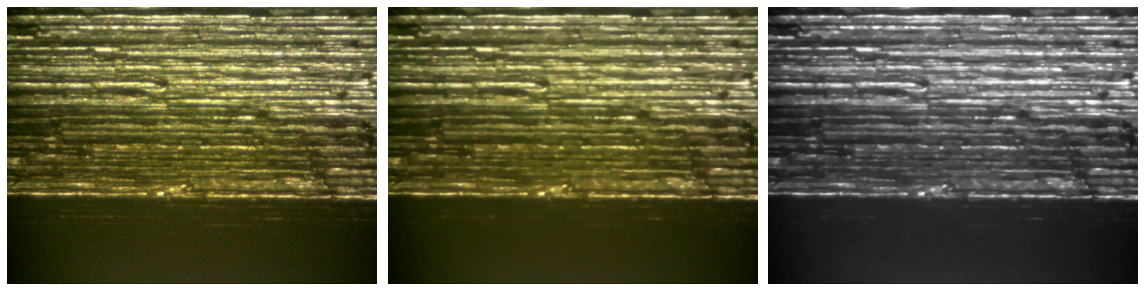

In [4]:
#Preprocessing
original_img =  np.array(Image.open(os.path.join(final_path, str(data_k.loc[0].img_name)+'.jpg')))
denoise = cv2.fastNlMeansDenoisingColored(original_img,None,10,10,7,21)
gray = cv2.cvtColor(denoise, cv2.COLOR_BGR2GRAY)

f, axs = plt.subplots(1,3,figsize=(16,6))

axs[0].imshow(original_img)
axs[0].axis('off')
axs[1].imshow(denoise)
axs[1].axis('off')
axs[2].imshow(gray, cmap='gray')
axs[2].axis('off')

f.tight_layout()
plt.savefig('burrs_preprocesing.png', dpi=200)
plt.show()

In [5]:
def remove_small_objects(image):
    final = np.invert(image)
    contours, hierarchy = cv2.findContours(final,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    final = image.copy()
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area<10000:
            mask = np.zeros(opening.shape,np.uint8)
            cv2.drawContours(mask,[cnt],0,255,-1)
            final = final+mask  
    return final

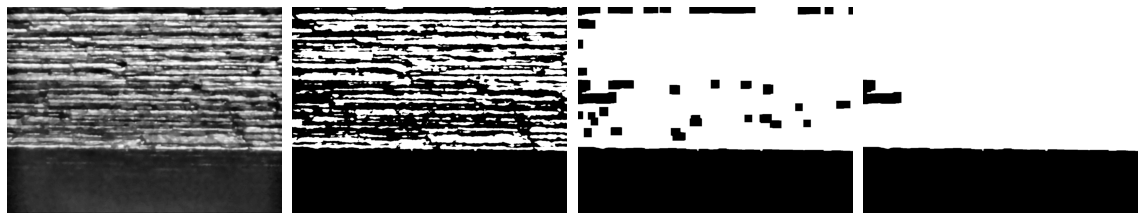

In [6]:
#Binarize
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
clahe_img = clahe.apply(gray)
_, otsu = cv2.threshold(clahe_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
kernel = np.ones((35,35),np.uint8)
opening = cv2.morphologyEx(otsu, cv2.MORPH_CLOSE, kernel)
clean = remove_small_objects(opening)

f, axs = plt.subplots(1,4,figsize=(16,10))

axs[0].imshow(clahe_img, cmap='gray')
axs[0].axis('off')
axs[1].imshow(otsu, cmap='gray')
axs[1].axis('off')
axs[2].imshow(opening, cmap='gray')
axs[2].axis('off')
axs[3].imshow(clean, cmap='gray')
axs[3].axis('off')

f.tight_layout()
plt.savefig('burrs_binarize.png', dpi=200)
plt.show()

In [7]:
def sections(img, width=1, heigth=1):
    sections_list = []
    dim_width = int(img.shape[1]/width)
    dim_heigth = int(img.shape[0]/heigth)
    total_pixels_section = dim_width*dim_heigth
    for i in range(0,width):
        for j in range(0,heigth):
            pos_width = dim_width*i
            pos_heigth = dim_heigth*j
            img_cut=img[pos_heigth:pos_heigth+dim_heigth,pos_width:pos_width+dim_width]
            sections_list.append((np.count_nonzero(img_cut == 255)*100)/total_pixels_section)
    return sections_list

In [8]:
def potentialSections(section_list):
    selection = []
    for i in range(0,len(section_list)-1):
        diff = abs(section_list[i] - section_list[i+1])
        if(diff>5):
            if(i not in selection):
                selection.append(i)
            selection.append(i+1)

    groups = []
    groups_diff = []
    for i in range(0, len(selection)-1):
        diff = abs(selection[i] - selection[i+1])
        if len(groups)==0 or (diff>5):
            group = []
            groups.append(group)
            group_diff = []
            groups_diff.append(group_diff)
        group = groups[-1]
        if (diff<5) and selection[i] not in group:
            group.append(selection[i])
        group.append(selection[i+1])
        diff_v = abs(section_list[selection[i]] - section_list[selection[i+1]])
        group_diff = groups_diff[-1]
        if (diff<5):
            group_diff.append(diff_v)

    max_value=0
    max_group = 0
    for i in range(0,len(groups_diff)):
        max_v = max(groups_diff[i])
        if max_v>max_value:
            max_value = max_v
            max_group = i
    if len(groups)>0:
        potentialGroup = groups[max_group]
    else:
        potentialGroup = []
    return [selection, groups, potentialGroup]

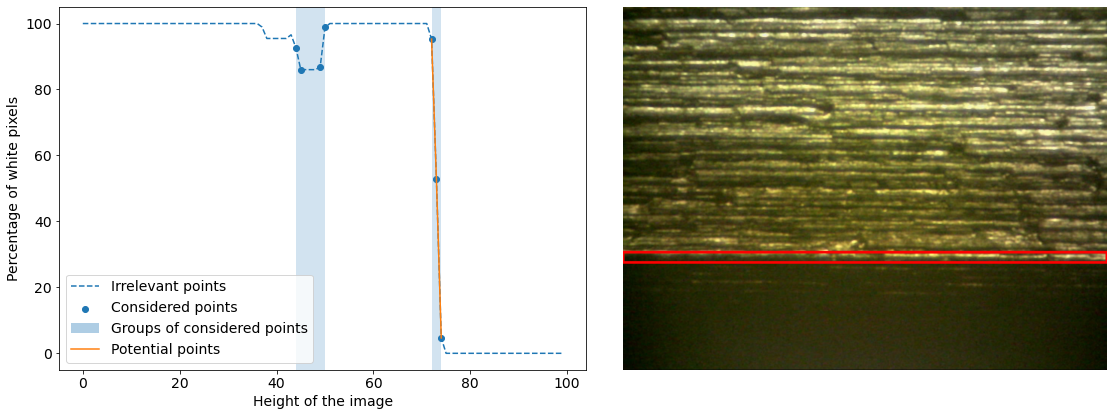

In [9]:
sections_img = sections(clean, heigth=100)
selection, groups, potentialGroup = potentialSections(sections_img)

img_final = original_img.copy()
dim_heigth = int(img_final.shape[0]/100)
cv2.rectangle(img_final, (0,dim_heigth*potentialGroup[0]), (clean.shape[1]-1,dim_heigth*potentialGroup[-1]+dim_heigth), (255, 0, 0), 5)

plt.rcParams.update({'font.size': 14})
f, axs = plt.subplots(1,2,figsize=(16,6))

i_ax = axs[0].plot(range(0,100), sections_img, '--', label='Irrelevant points')
c_ax = axs[0].scatter(selection, [sections_img[i] for i in selection], label='Considered points')
p_ax = axs[0].plot(potentialGroup, [sections_img[i] for i in potentialGroup], label='Potential points')
gs_ax = []
for id_group, group in zip(range(1,len(groups)+1), groups):
    g_ax = axs[0].axvspan(group[0], group[-1], alpha=0.2, lw=0)
    gs_ax.append(g_ax)

axs[0].set_ylabel('Percentage of white pixels')
axs[0].set_xlabel('Height of the image')
l = axs[0].legend([i_ax[0], c_ax, tuple(gs_ax), p_ax[0]],['Irrelevant points', 'Considered points', 'Groups of considered points', 'Potential points'])

axs[1].imshow(img_final)
axs[1].axis('off')

f.tight_layout()
plt.savefig('burrs_detection.png', dpi=200)
plt.show()

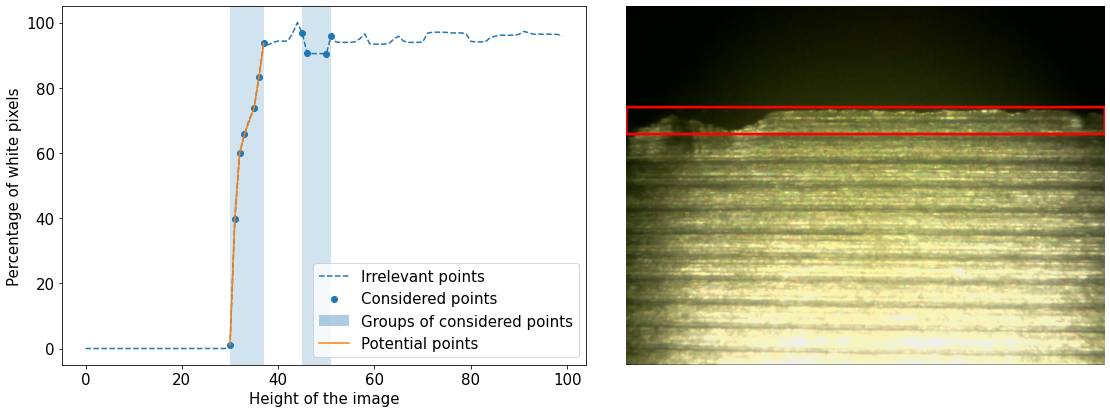

In [10]:
original_img =  np.array(Image.open(os.path.join(final_path, str(data_b.loc[8].img_name)+'.jpg')))
denoise = cv2.fastNlMeansDenoisingColored(original_img,None,10,10,7,21)
gray = cv2.cvtColor(denoise, cv2.COLOR_BGR2GRAY)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
clahe_img = clahe.apply(gray)
_, otsu = cv2.threshold(clahe_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
kernel = np.ones((35,35),np.uint8)
opening = cv2.morphologyEx(otsu, cv2.MORPH_CLOSE, kernel)
clean = remove_small_objects(opening)
sections_img = sections(clean, heigth=100)
selection, groups, potentialGroup = potentialSections(sections_img)

img_final = original_img.copy()
dim_heigth = int(img_final.shape[0]/100)
cv2.rectangle(img_final, (0,dim_heigth*potentialGroup[0]), (clean.shape[1]-1,dim_heigth*potentialGroup[-1]+dim_heigth), (255, 0, 0), 5)

plt.rcParams.update({'font.size': 15})
f, axs = plt.subplots(1,2,figsize=(16,6))

i_ax = axs[0].plot(range(0,100), sections_img, '--', label='Irrelevant points')
c_ax = axs[0].scatter(selection, [sections_img[i] for i in selection], label='Considered points')
p_ax = axs[0].plot(potentialGroup, [sections_img[i] for i in potentialGroup], label='Potential points')
gs_ax = []
for id_group, group in zip(range(1,len(groups)+1), groups):
    g_ax = axs[0].axvspan(group[0], group[-1], alpha=0.2, lw=0)
    gs_ax.append(g_ax)

axs[0].set_ylabel('Percentage of white pixels')
axs[0].set_xlabel('Height of the image')
l = axs[0].legend([i_ax[0], c_ax, tuple(gs_ax), p_ax[0]],['Irrelevant points', 'Considered points', 'Groups of considered points', 'Potential points'])

axs[1].imshow(img_final)
axs[1].axis('off')

f.tight_layout()
plt.savefig('burrs_detection2.png', dpi=200)
plt.show()

In [11]:
def complete_process(img_name):
    original_img =  np.array(Image.open(os.path.join(final_path, img_name+'.jpg')))
    denoise = cv2.fastNlMeansDenoisingColored(original_img,None,10,10,7,21)
    gray = cv2.cvtColor(denoise, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(gray)
    _, otsu = cv2.threshold(clahe_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    kernel = np.ones((35,35),np.uint8)
    opening = cv2.morphologyEx(otsu, cv2.MORPH_CLOSE, kernel)    
    clean = remove_small_objects(opening)
    sections_img = sections(clean, heigth=100)
    selection, groups, potentialGroup = potentialSections(sections_img)

    dim_heigth = int(img_final.shape[0]/100)
    upper_height = dim_heigth*(potentialGroup[0]-5) if potentialGroup[0]>5 else 0
    bottom_height = dim_heigth*potentialGroup[-1]+(dim_heigth*5) if potentialGroup[0]<94 else dim_heigth-1
    img_cut=original_img[upper_height:bottom_height,:,:]
    img_cut_binary=clean[upper_height:bottom_height,:]
    
    return [original_img, img_cut, img_cut_binary, sections_img, selection, groups, potentialGroup]

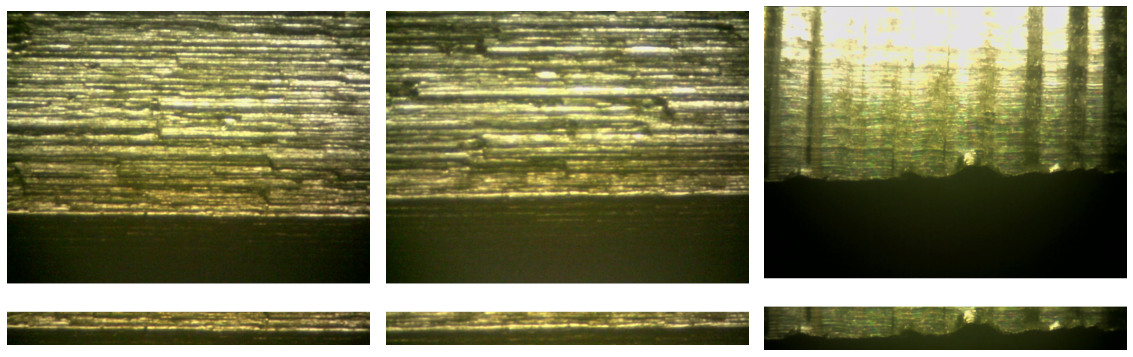

In [12]:
white_space = np.ones((100,original_img.shape[1],3),np.uint8)*255

img_k, img_k_cut, img_k_cutb, sections_k, selection_k, groups_k, potential_k = complete_process(str(data_k.loc[3].img_name))
final_k = np.concatenate((img_k, white_space,img_k_cut), axis = 0)

img_s, img_s_cut, img_s_cutb, sections_s, selection_s, groups_s, potential_s = complete_process(str(data_s.loc[6].img_name))
final_s = np.concatenate((img_s, white_space,img_s_cut), axis = 0)

img_b, img_b_cut, img_b_cutb, sections_b, selection_b, groups_b, potential_b = complete_process(str(data_b.loc[11].img_name))
final_b = np.concatenate((img_b, white_space,img_b_cut), axis = 0)

f, axs = plt.subplots(1,3,figsize=(16,8))

axs[0].imshow(final_k)
axs[0].axis('off')
axs[1].imshow(final_s)
axs[1].axis('off')
axs[2].imshow(final_b)
axs[2].axis('off')

f.tight_layout()
plt.savefig('burrs_dataset.png', dpi=200)
plt.show()

In [13]:
def linear_regression(X_points, y_values):
    X = np.array(X_points).reshape(-1,1)
    y = np.array(y_values).reshape(-1,1)
    reg = linear_model.LinearRegression().fit(X, y)
    m = float(reg.coef_[0][0])
    n = float(reg.intercept_[0])
    high_point = (100-n)/m
    low_point = (-n)/m
    return [m, n, high_point, low_point]

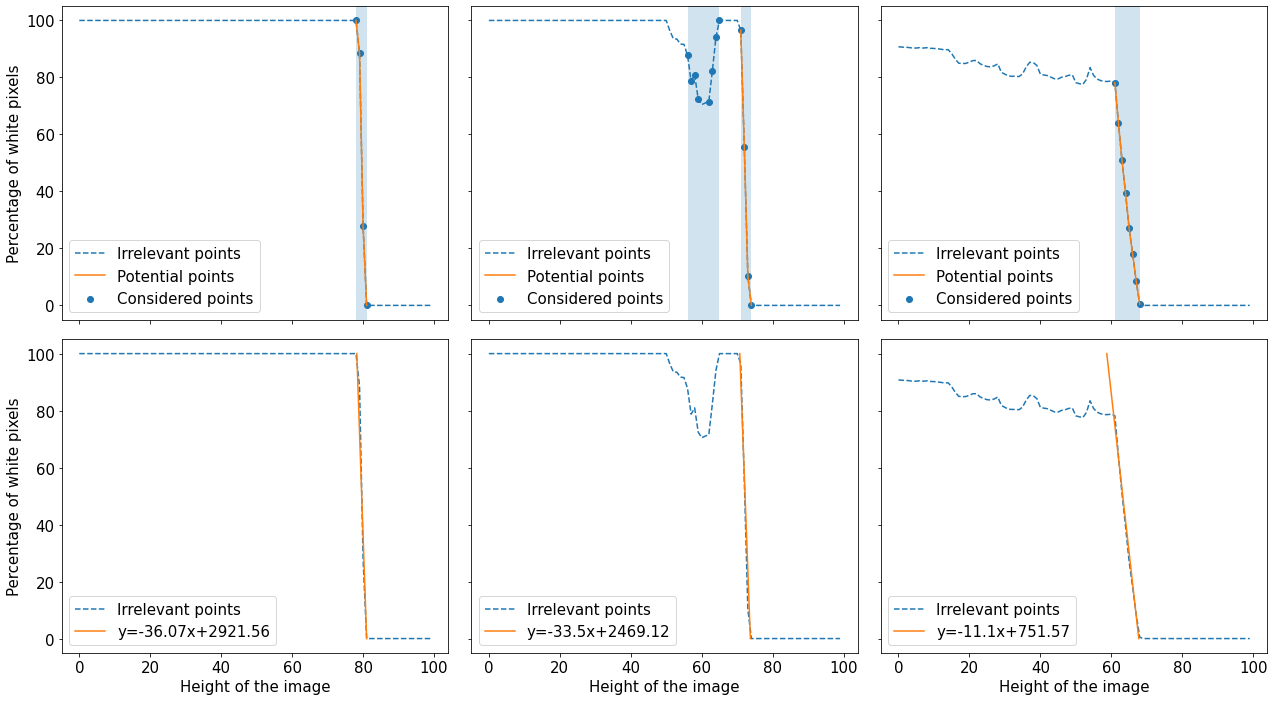

In [14]:
f, axs = plt.subplots(2,3,figsize=(18,10), sharey='row', sharex='col')

axs[0][0].plot(range(0,100), sections_k, '--', label='Irrelevant points')
axs[0][0].scatter(selection_k, [sections_k[i] for i in selection_k], label='Considered points')
axs[0][0].plot(potential_k, [sections_k[i] for i in potential_k], label='Potential points')
gs_ax = []
for id_group, group in zip(range(1,len(groups_k)+1), groups_k):
    g_ax = axs[0][0].axvspan(group[0], group[-1], alpha=0.2, lw=0)
m_k, n_k, high_point_k, low_point_k = linear_regression(potential_k, [sections_k[i] for i in potential_k])
axs[1][0].plot(range(0,100), sections_k, '--', label='Irrelevant points')
axs[1][0].plot([high_point_k, low_point_k], [100,0], label='y='+str(round(m_k,2))+'x+'+str(round(n_k,2)))
axs[1][0].legend()
axs[0][0].legend()

axs[0][1].plot(range(0,100), sections_s, '--', label='Irrelevant points')
axs[0][1].scatter(selection_s, [sections_s[i] for i in selection_s], label='Considered points')
axs[0][1].plot(potential_s, [sections_s[i] for i in potential_s], label='Potential points')
gs_ax = []
for id_group, group in zip(range(1,len(groups_s)+1), groups_s):
    g_ax = axs[0][1].axvspan(group[0], group[-1], alpha=0.2, lw=0)
m_s, n_s, high_point_s, low_point_s = linear_regression(potential_s, [sections_s[i] for i in potential_s])
axs[1][1].plot(range(0,100), sections_s, '--', label='Irrelevant points')
axs[1][1].plot([high_point_s, low_point_s], [100,0], label='y='+str(round(m_s,2))+'x+'+str(round(n_s,2)))
axs[1][1].legend()
axs[0][1].legend()
    
axs[0][2].plot(range(0,100), sections_b, '--', label='Irrelevant points')
axs[0][2].scatter(selection_b, [sections_b[i] for i in selection_b], label='Considered points')
axs[0][2].plot(potential_b, [sections_b[i] for i in potential_b], label='Potential points')
gs_ax = []
for id_group, group in zip(range(1,len(groups_b)+1), groups_b):
    g_ax = axs[0][2].axvspan(group[0], group[-1], alpha=0.2, lw=0)
m_b, n_b, high_point_b, low_point_b = linear_regression(potential_b, [sections_b[i] for i in potential_b])
axs[1][2].plot(range(0,100), sections_b, '--', label='Irrelevant points')
axs[1][2].plot([high_point_b, low_point_b], [100,0], label='y='+str(round(m_b,2))+'x+'+str(round(n_b,2)))
axs[1][2].legend()
axs[0][2].legend()

axs[0][0].set_ylabel('Percentage of white pixels')
axs[1][0].set_ylabel('Percentage of white pixels')
axs[1][0].set_xlabel('Height of the image')
axs[1][1].set_xlabel('Height of the image')
axs[1][2].set_xlabel('Height of the image')

f.tight_layout()
plt.savefig('burrs_linear.png', dpi=200)
plt.show()

In [15]:
def biggest_contour_area(image):
    contours,_ = cv2.findContours(image,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)
    biggest_contour = []
    biggest_area = 0
    for contour in contours:
        area = cv2.contourArea(contour)
        if area>biggest_area:
            biggest_contour = contour
            biggest_area = area
    return biggest_contour

In [16]:
def min_max_contour(contour, rows, cols):
    min_col0 = rows
    max_col0 = 0
    min_cols = rows
    max_cols = 0
    cnt = []
    for point in contour:
        if point[0][0]==0:
            if point[0][1]> max_col0:
                max_col0 = point[0][1]
            if point[0][1]< min_col0:
                min_col0 = point[0][1]
        if point[0][0]==(cols-1):
            if point[0][1]> max_cols:
                max_cols = point[0][1]
            if point[0][1]< min_cols:
                min_cols = point[0][1]
        cnt.append([point[0][0], point[0][1]])
    return [min_col0,max_col0, min_cols,max_cols, cnt]

In [17]:
def line_contour(sign, min_col0,max_col0, min_cols,max_cols, contour, cols):
    if sign==1:
        begin_point = [0,max_col0]
        if begin_point not in contour:
            cnt_sort = sorted(contour, key= lambda x: [x[0],x[1]])
            list0 = [a for a in cnt_sort if a[0] == cnt_sort[0][0]]
            begin_point = list0[-1]
        end_point = [cols-1,max_cols]
        if end_point not in contour:
            cnt_sort = sorted(contour, key= lambda x: [x[0],x[1]])
            list0 = [a for a in cnt_sort if a[0] == cnt_sort[-1][0]]
            end_point = list0[0]
    else: 
        begin_point = [0,min_col0]
        if begin_point not in contour:
            cnt_sort = sorted(contour, key= lambda x: [x[0],x[1]])
            list0 = [a for a in cnt_sort if a[0] == cnt_sort[0][0]]
            begin_point = list0[0]
        end_point = [cols-1,min_cols]
        if end_point not in contour:
            cnt_sort = sorted(contour, key= lambda x: [x[0],x[1]])
            list0 = [a for a in cnt_sort if a[0] == cnt_sort[-1][0]]
            end_point = list0[-1]
    index_begin = contour.index(begin_point)
    index_end = contour.index(end_point)
    contour_line = contour[index_begin:index_end+1]
    if contour_line[1][0]==0:
        contour_line = contour[index_end:] + contour[:index_begin+1]
        
    min_line = begin_point[1]
    max_line = 0
    for point in contour_line:
        if point[1]<min_line:
            min_line = point[1]
        if point[1]>max_line:
            max_line = point[1]
    return [contour_line, min_line, max_line]

In [18]:
def percentage_white_pixels(image, height):
    img_cut1 = image[0:height+1,:]
    total_pixels_section = img_cut1.shape[0]*img_cut1.shape[1]
    pixels1 = np.count_nonzero(img_cut1 == 255)
    pwp1 = (pixels1*100)/total_pixels_section
    
    img_cut2 = image[height:image.shape[0],:]
    total_pixels_section = img_cut2.shape[0]*img_cut2.shape[1]
    pixels2= np.count_nonzero(img_cut2 == 255)
    pwp2 = (pixels2*100)/total_pixels_section
    return [pwp1, pwp2, pixels1, pixels2]

In [19]:
def pwp(sign, image, min_line, max_line, middle):
    if sign == 1:        
        if max_line == image.shape[0] -1:
            _, _, pixels_limit ,  _= percentage_white_pixels(image, int(max_line))
        else:
            _, _, pixels_limit ,  _= percentage_white_pixels(image, int(max_line+1))
        _, _, pixels_middle ,  _= percentage_white_pixels(image, int(middle+1))
    else:
        if min_line == 0:
            _, _, _,  pixels_limit= percentage_white_pixels(image, int(min_line))
        else:
            _, _, _,  pixels_limit= percentage_white_pixels(image, int(min_line-1))
        _, _, _,  pixels_middle= percentage_white_pixels(image, int(middle-1))
    total_pixels = image.shape[0]*image.shape[1]
    pwp_limit  =  pixels_limit/total_pixels
    pwp_middle  = pixels_middle/total_pixels
    return [pwp_limit, pwp_middle]

In [20]:
def contour_complete(sign, cols, min_line, max_line):
    if sign == 1:
        beginning_point = [0,min_line]
        ending_point = [cols-1,min_line]
    else:
        beginning_point = [0,max_line]
        ending_point = [cols-1,max_line]

    if contour_line[0][0] == 0:
        complete_contour = np.array([beginning_point] + contour_line + [ending_point], dtype=np.int32)
    else:
        complete_contour = np.array([ending_point] + contour_line + [beginning_point], dtype=np.int32)
    return complete_contour

In [21]:
y_values = [sections_k[i] for i in potential_k]
if y_values[0]>y_values[-1]:
    sign= 1
else: 
    sign = -1

biggest_contour = biggest_contour_area(img_k_cutb)
if len(biggest_contour)>0:
    min_col0,max_col0, min_cols,max_cols, contour = min_max_contour(biggest_contour, img_k_cutb.shape[0], img_k_cutb.shape[1])    
    contour_line, min_line, max_line = line_contour(sign, min_col0,max_col0, min_cols,max_cols, contour, img_k_cutb.shape[1])
    
    middle = int((min_line+max_line)/2)
    dist = max_line - min_line
        
    pwp_limit, pwp_middle = pwp(sign, img_k_cutb, min_line, max_line, middle)
    complete_contour = contour_complete(sign, img_k_cutb.shape[1], min_line, max_line)

    area = cv2.contourArea(complete_contour)
    x_bb,y_bb,w_bb,h_bb = cv2.boundingRect(complete_contour)
    rect_area = w_bb*h_bb
    extent = float(area)/rect_area

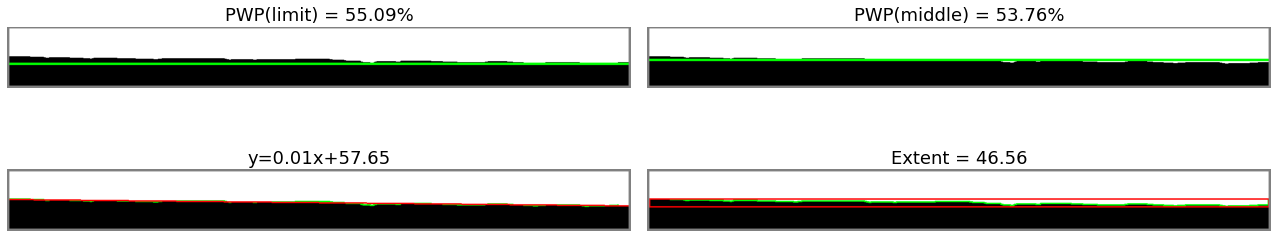

In [22]:
img = cv2.cvtColor(img_k_cutb,cv2.COLOR_GRAY2RGB)
cols = img_k_cutb.shape[1]
f, axs = plt.subplots(2,2,figsize=(18,5))

line_cnt = img.copy()
for i in range(0, len(contour_line)-2):
    cv2.line(line_cnt, contour_line[i], contour_line[i+1], (0,255,0), 2)
line_point = np.array(contour_line , dtype=np.int32)
X = np.reshape(line_point[:,0], (len(line_point), -1))
y = line_point[:,1]
reg = linear_model.LinearRegression().fit(X, y)
m = float(reg.coef_[0])
n = float(reg.intercept_)
p1 = int((m*0)+n)
p2 = int((m*(cols-1))+n)
cv2.line(line_cnt, (0,p1), (cols-1,p2), (255,0,0), 2)
line_cnt = cv2.copyMakeBorder(line_cnt,5,5,5,5,cv2.BORDER_CONSTANT,value=(128, 128, 128))
axs[1][0].imshow(line_cnt)
axs[1][0].axis('off')
axs[1][0].title.set_text('y='+str(round(m,2))+'x+'+str(round(n,2)))

pwp_line_middle = img.copy()
pwp_line_limit = img.copy()
if sign == 1:
    cv2.line(pwp_line_limit, (0,int(max_line+1)), (cols-1,int(max_line+1)), (0,255,0), 4)
    cv2.line(pwp_line_middle, (0,int(middle+1)), (cols-1,int(middle+1)), (0,255,0), 4)
else:
    cv2.line(pwp_line_limit, (0,int(min_line-1)), (cols-1,int(min_line-1)), (0,255,0), 4)
    cv2.line(pwp_line_middle, (0,int(middle-1)), (cols-1,int(middle-1)), (0,255,0), 4)    
pwp_line_middle = cv2.copyMakeBorder(pwp_line_middle,5,5,5,5,cv2.BORDER_CONSTANT,value=(128, 128, 128))
pwp_line_limit = cv2.copyMakeBorder(pwp_line_limit,5,5,5,5,cv2.BORDER_CONSTANT,value=(128, 128, 128))
axs[0][1].imshow(pwp_line_middle)
axs[0][1].axis('off')
axs[0][1].title.set_text('PWP(middle) = '+str(round(pwp_middle*100,2))+"%")
axs[0][0].imshow(pwp_line_limit, cmap='gray')
axs[0][0].axis('off')
axs[0][0].title.set_text('PWP(limit) = '+str(round(pwp_limit*100,2))+"%")

complete_cnt = img.copy()
cv2.drawContours(complete_cnt, [complete_contour], 0, (0,255,0), 2)
cv2.rectangle(complete_cnt,(x_bb,y_bb),(x_bb+w_bb,y_bb+h_bb),(255,0,0),2)
complete_cnt = cv2.copyMakeBorder(complete_cnt,5,5,5,5,cv2.BORDER_CONSTANT,value=(128, 128, 128))
axs[1][1].imshow(complete_cnt)
axs[1][1].axis('off')
axs[1][1].title.set_text('Extent = '+str(round(extent*100,2)))

f.tight_layout()
plt.savefig('burrs_contours.png', dpi=200)
plt.show()

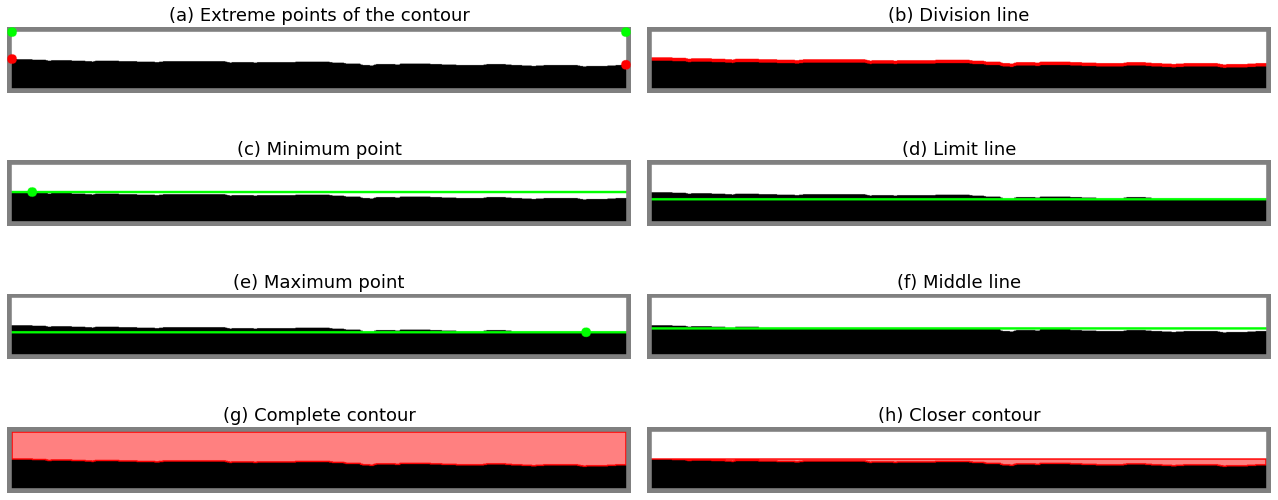

In [23]:
f, axs = plt.subplots(4,2,figsize=(18,8))
height, width= img_k_cutb.shape
border_size=10

border_points = img.copy()
border_points = cv2.copyMakeBorder(border_points,border_size,border_size,border_size,border_size,cv2.BORDER_CONSTANT,value=(128, 128, 128))

cv2.circle(border_points, (0+border_size,min_col0+border_size), 10, (0,255,0), -1)
cv2.circle(border_points, (0+border_size,max_col0+border_size), 10, (255,0,0), -1)

cv2.circle(border_points, (width-1+border_size,min_cols+border_size), 10, (0,255,0), -1)
cv2.circle(border_points, (width-1+border_size,max_cols+border_size), 10, (255,0,0), -1)

axs[0][0].imshow(border_points)
axs[0][0].axis('off')
axs[0][0].title.set_text("(a) Extreme points of the contour")


division_line = img.copy()
min_point=contour_line[0]
max_point=contour_line[0]
for i in range(1,len(contour_line)):
    cv2.line(division_line, contour_line[i-1],contour_line[i], (255,0,0), 5)
    if contour_line[i][1] == min_line:
        min_point = contour_line[i]
    if contour_line[i][1] == max_line:
        max_point = contour_line[i]
division_line = cv2.copyMakeBorder(division_line,border_size,border_size,border_size,border_size,cv2.BORDER_CONSTANT,value=(128, 128, 128))
axs[0][1].imshow(division_line)
axs[0][1].axis('off')
axs[0][1].title.set_text("(b) Division line")

min_max_points = img.copy()
cv2.circle(min_max_points, (min_point[0],min_point[1]), 10, (0,255,0), -1)
cv2.line(min_max_points, (0,min_line),(width-1,min_line), (0,255,0), 3)

min_max_points = cv2.copyMakeBorder(min_max_points,border_size,border_size,border_size,border_size,cv2.BORDER_CONSTANT,value=(128, 128, 128))
axs[1][0].imshow(min_max_points)
axs[1][0].axis('off')
axs[1][0].title.set_text("(c) Minimum point")

min_max_points = img.copy()
cv2.circle(min_max_points, (max_point[0],max_point[1]), 10, (0,255,0), -1)
cv2.line(min_max_points, (0,max_line),(width-1,max_line), (0,255,0), 3)

min_max_points = cv2.copyMakeBorder(min_max_points,border_size,border_size,border_size,border_size,cv2.BORDER_CONSTANT,value=(128, 128, 128))
axs[2][0].imshow(min_max_points)
axs[2][0].axis('off')
axs[2][0].title.set_text("(e) Maximum point")

min_max_points = img.copy()
cv2.line(min_max_points, (0,max_line),(width-1,max_line), (0,255,0), 3)

min_max_points = cv2.copyMakeBorder(min_max_points,border_size,border_size,border_size,border_size,cv2.BORDER_CONSTANT,value=(128, 128, 128))
axs[1][1].imshow(min_max_points)
axs[1][1].axis('off')
axs[1][1].title.set_text("(d) Limit line")

min_max_points = img.copy()
cv2.line(min_max_points, (0,middle),(width-1,middle), (0,255,0), 3)

min_max_points = cv2.copyMakeBorder(min_max_points,border_size,border_size,border_size,border_size,cv2.BORDER_CONSTANT,value=(128, 128, 128))
axs[2][1].imshow(min_max_points)
axs[2][1].axis('off')
axs[2][1].title.set_text("(f) Middle line")

final_cnt = img.copy()
cv2.drawContours(final_cnt, [biggest_contour], 0, (255,0,0), -1)
alpha = 0.5
final_cnt = cv2.addWeighted(img, 1-alpha, final_cnt, alpha, 0)
cv2.drawContours(final_cnt, [biggest_contour], 0, (255,0,0), 2)
final_cnt = cv2.copyMakeBorder(final_cnt,border_size,border_size,border_size,border_size,cv2.BORDER_CONSTANT,value=(128, 128, 128))

axs[3][0].imshow(final_cnt)
axs[3][0].axis('off')
axs[3][0].title.set_text("(g) Complete contour")

final_cnt = img.copy()
cv2.drawContours(final_cnt, [complete_contour], 0, (255,0,0), -1)
alpha = 0.5
final_cnt = cv2.addWeighted(img, 1-alpha, final_cnt, alpha, 0)
cv2.drawContours(final_cnt, [complete_contour], 0, (255,0,0), 2)
final_cnt = cv2.copyMakeBorder(final_cnt,border_size,border_size,border_size,border_size,cv2.BORDER_CONSTANT,value=(128, 128, 128))

axs[3][1].imshow(final_cnt)
axs[3][1].axis('off')
axs[3][1].title.set_text("(h) Closer contour")

f.tight_layout()
plt.savefig('burrs_process.png', dpi=200)
plt.show()

In [24]:
y_values = [sections_s[i] for i in potential_s]
if y_values[0]>y_values[-1]:
    sign= 1
else: 
    sign = -1

biggest_contour = biggest_contour_area(img_s_cutb)
if len(biggest_contour)>0:
    min_col0,max_col0, min_cols,max_cols, contour = min_max_contour(biggest_contour, img_s_cutb.shape[0], img_s_cutb.shape[1])    
    contour_line, min_line, max_line = line_contour(sign, min_col0,max_col0, min_cols,max_cols, contour, img_s_cutb.shape[1])
    
    middle = int((min_line+max_line)/2)
    dist = max_line - min_line
        
    pwp_limit, pwp_middle = pwp(sign, img_s_cutb, min_line, max_line, middle)
    complete_contour = contour_complete(sign, img_s_cutb.shape[1], min_line, max_line)

    area = cv2.contourArea(complete_contour)
    x_bb,y_bb,w_bb,h_bb = cv2.boundingRect(complete_contour)
    rect_area = w_bb*h_bb
    extent = float(area)/rect_area

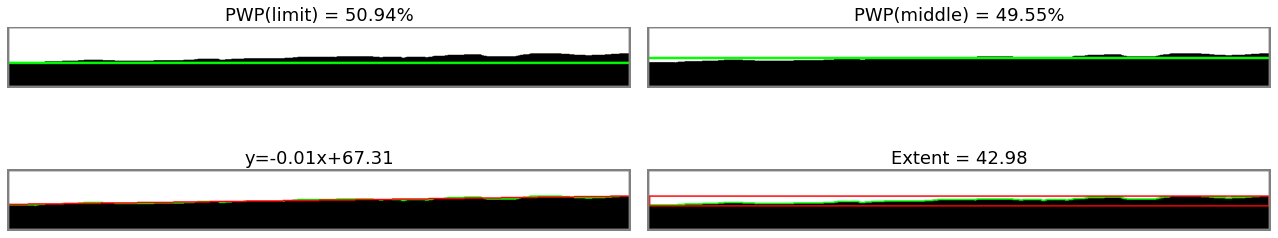

In [25]:
img = cv2.cvtColor(img_s_cutb,cv2.COLOR_GRAY2RGB)
cols = img_s_cutb.shape[1]
f, axs = plt.subplots(2,2,figsize=(18,5))

line_cnt = img.copy()
for i in range(0, len(contour_line)-2):
    cv2.line(line_cnt, contour_line[i], contour_line[i+1], (0,255,0), 2)
line_point = np.array(contour_line , dtype=np.int32)
X = np.reshape(line_point[:,0], (len(line_point), -1))
y = line_point[:,1]
reg = linear_model.LinearRegression().fit(X, y)
m = float(reg.coef_[0])
n = float(reg.intercept_)
p1 = int((m*0)+n)
p2 = int((m*(cols-1))+n)
cv2.line(line_cnt, (0,p1), (cols-1,p2), (255,0,0), 2)
line_cnt = cv2.copyMakeBorder(line_cnt,5,5,5,5,cv2.BORDER_CONSTANT,value=(128, 128, 128))
axs[1][0].imshow(line_cnt)
axs[1][0].axis('off')
axs[1][0].title.set_text('y='+str(round(m,2))+'x+'+str(round(n,2)))

pwp_line_middle = img.copy()
pwp_line_limit = img.copy()
if sign == 1:
    cv2.line(pwp_line_limit, (0,int(max_line+1)), (cols-1,int(max_line+1)), (0,255,0), 4)
    cv2.line(pwp_line_middle, (0,int(middle+1)), (cols-1,int(middle+1)), (0,255,0), 4)
else:
    cv2.line(pwp_line_limit, (0,int(min_line-1)), (cols-1,int(min_line-1)), (0,255,0), 4)
    cv2.line(pwp_line_middle, (0,int(middle-1)), (cols-1,int(middle-1)), (0,255,0), 4)    
pwp_line_middle = cv2.copyMakeBorder(pwp_line_middle,5,5,5,5,cv2.BORDER_CONSTANT,value=(128, 128, 128))
pwp_line_limit = cv2.copyMakeBorder(pwp_line_limit,5,5,5,5,cv2.BORDER_CONSTANT,value=(128, 128, 128))
axs[0][1].imshow(pwp_line_middle)
axs[0][1].axis('off')
axs[0][1].title.set_text('PWP(middle) = '+str(round(pwp_middle*100,2))+"%")
axs[0][0].imshow(pwp_line_limit, cmap='gray')
axs[0][0].axis('off')
axs[0][0].title.set_text('PWP(limit) = '+str(round(pwp_limit*100,2))+"%")

complete_cnt = img.copy()
cv2.drawContours(complete_cnt, [complete_contour], 0, (0,255,0), 2)
cv2.rectangle(complete_cnt,(x_bb,y_bb),(x_bb+w_bb,y_bb+h_bb),(255,0,0),2)
complete_cnt = cv2.copyMakeBorder(complete_cnt,5,5,5,5,cv2.BORDER_CONSTANT,value=(128, 128, 128))
axs[1][1].imshow(complete_cnt)
axs[1][1].axis('off')
axs[1][1].title.set_text('Extent = '+str(round(extent*100,2)))

f.tight_layout()
plt.savefig('burrs_contours_s.png', dpi=200)
plt.show()

In [26]:
y_values = [sections_b[i] for i in potential_b]
if y_values[0]>y_values[-1]:
    sign= 1
else: 
    sign = -1

biggest_contour = biggest_contour_area(img_b_cutb)
if len(biggest_contour)>0:
    min_col0,max_col0, min_cols,max_cols, contour = min_max_contour(biggest_contour, img_b_cutb.shape[0], img_b_cutb.shape[1])    
    contour_line, min_line, max_line = line_contour(sign, min_col0,max_col0, min_cols,max_cols, contour, img_b_cutb.shape[1])
    
    middle = int((min_line+max_line)/2)
    dist = max_line - min_line
        
    pwp_limit, pwp_middle = pwp(sign, img_b_cutb, min_line, max_line, middle)
    complete_contour = contour_complete(sign, img_b_cutb.shape[1], min_line, max_line)

    area = cv2.contourArea(complete_contour)
    x_bb,y_bb,w_bb,h_bb = cv2.boundingRect(complete_contour)
    rect_area = w_bb*h_bb
    extent = float(area)/rect_area

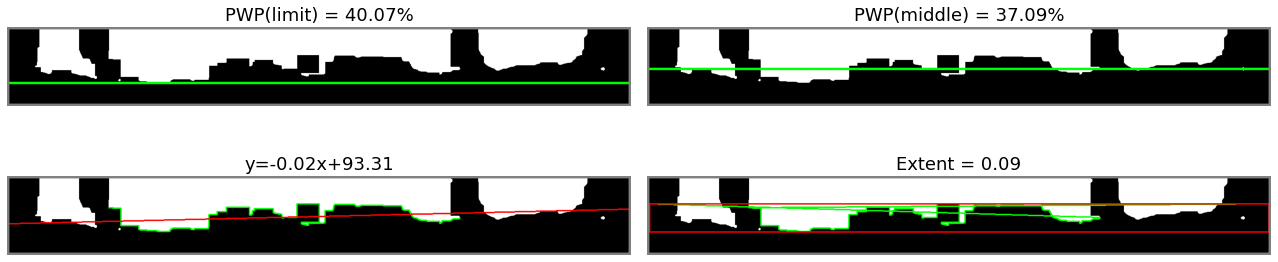

In [27]:
img = cv2.cvtColor(img_b_cutb,cv2.COLOR_GRAY2RGB)
cols = img_b_cutb.shape[1]
f, axs = plt.subplots(2,2,figsize=(18,5))

line_cnt = img.copy()
for i in range(0, len(contour_line)-2):
    cv2.line(line_cnt, contour_line[i], contour_line[i+1], (0,255,0), 2)
line_point = np.array(contour_line , dtype=np.int32)
X = np.reshape(line_point[:,0], (len(line_point), -1))
y = line_point[:,1]
reg = linear_model.LinearRegression().fit(X, y)
m = float(reg.coef_[0])
n = float(reg.intercept_)
p1 = int((m*0)+n)
p2 = int((m*(cols-1))+n)
cv2.line(line_cnt, (0,p1), (cols-1,p2), (255,0,0), 2)
line_cnt = cv2.copyMakeBorder(line_cnt,5,5,5,5,cv2.BORDER_CONSTANT,value=(128, 128, 128))
axs[1][0].imshow(line_cnt)
axs[1][0].axis('off')
axs[1][0].title.set_text('y='+str(round(m,2))+'x+'+str(round(n,2)))

pwp_line_middle = img.copy()
pwp_line_limit = img.copy()
if sign == 1:
    cv2.line(pwp_line_limit, (0,int(max_line+1)), (cols-1,int(max_line+1)), (0,255,0), 4)
    cv2.line(pwp_line_middle, (0,int(middle+1)), (cols-1,int(middle+1)), (0,255,0), 4)
else:
    cv2.line(pwp_line_limit, (0,int(min_line-1)), (cols-1,int(min_line-1)), (0,255,0), 4)
    cv2.line(pwp_line_middle, (0,int(middle-1)), (cols-1,int(middle-1)), (0,255,0), 4)    
pwp_line_middle = cv2.copyMakeBorder(pwp_line_middle,5,5,5,5,cv2.BORDER_CONSTANT,value=(128, 128, 128))
pwp_line_limit = cv2.copyMakeBorder(pwp_line_limit,5,5,5,5,cv2.BORDER_CONSTANT,value=(128, 128, 128))
axs[0][1].imshow(pwp_line_middle)
axs[0][1].axis('off')
axs[0][1].title.set_text('PWP(middle) = '+str(round(pwp_middle*100,2))+"%")
axs[0][0].imshow(pwp_line_limit, cmap='gray')
axs[0][0].axis('off')
axs[0][0].title.set_text('PWP(limit) = '+str(round(pwp_limit*100,2))+"%")

complete_cnt = img.copy()
cv2.drawContours(complete_cnt, [complete_contour], 0, (0,255,0), 2)
cv2.rectangle(complete_cnt,(x_bb,y_bb),(x_bb+w_bb,y_bb+h_bb),(255,0,0),2)
complete_cnt = cv2.copyMakeBorder(complete_cnt,5,5,5,5,cv2.BORDER_CONSTANT,value=(128, 128, 128))
axs[1][1].imshow(complete_cnt)
axs[1][1].axis('off')
axs[1][1].title.set_text('Extent = '+str(round(extent*100,2)))

f.tight_layout()
plt.savefig('burrs_contours_b.png', dpi=200)
plt.show()